In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


## Plotting initial concentration profiles

In [4]:
# all Z's are the same! Just call it z.

In [5]:
z, c_original = compute_c_profile("density_hw_original_288.xvg")
z_1, c_1 = compute_c_profile("density_hw_r1_288.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hw_r2_288.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hw_r3_288.xvg")  # replicate 3


In [6]:
# Example concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

Note: I think it is somewhat more rigorous to normalize the densities, since we know what the total number must be. This eliminated one source of error 

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
Ntrue = 188
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    c /= (N_s/Ntrue)
# verify normalization worked.
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    

188.00496817343995
188.18428364160002
187.98510751343997
188.10112932479998
188.00000000000006
187.99999999999997
188.00000000000006
188.00000000000006


/tmp/ipykernel_378695/2150603121.py:5: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

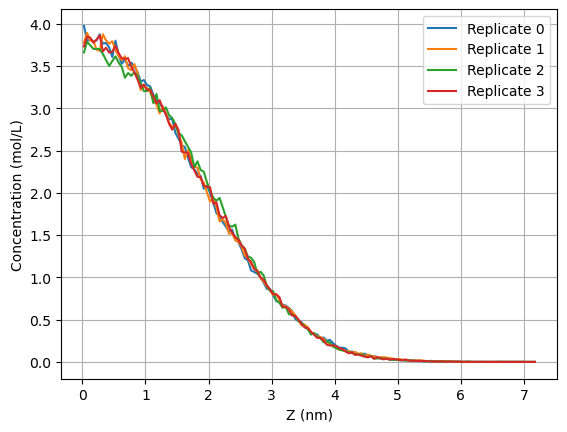

In [8]:
# Plot the concentration profiles
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Bootstrapping concentration profiles

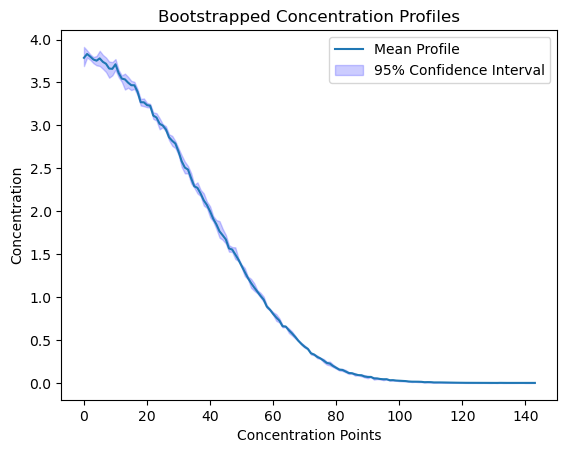

In [9]:
# Example concentration profiles
concentration_profiles = [c_original,c_1,c_2,c_3]

# Number of bootstrap samples
n_bootstrap = 1000

# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples):
    bootstrap_means = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        bootstrap_means.append(mean_profile)
    return np.array(bootstrap_means)

# Perform bootstrapping
bootstrap_means = bootstrap_profiles(concentration_profiles, n_bootstrap)

# Calculate the mean and 95% confidence intervals for each point
#mean_profile = np.mean(bootstrap_means, axis=0)

#Better to use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
lower_bound = np.percentile(bootstrap_means, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_means, 97.5, axis=0)

c_0 = mean_profile
# Plotting the results
conc_points = range(len(c_0))
plt.plot(conc_points, c_0, label='Mean Profile')
plt.fill_between(conc_points, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration Points')
plt.ylabel('Concentration')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()

/tmp/ipykernel_378695/2730136378.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(z, np.log(c_0), label='Mean Profile')


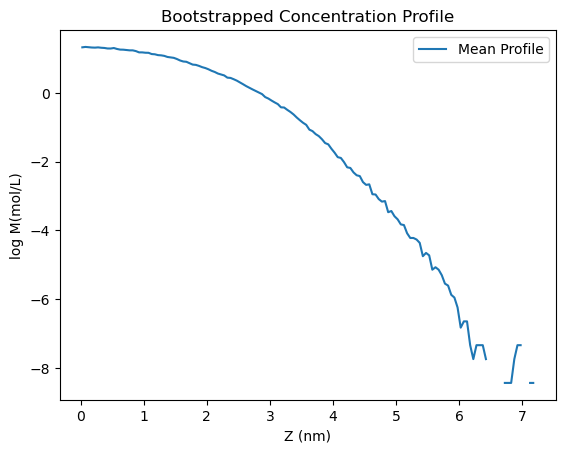

In [10]:
# Plotting the results
plt.plot(z, np.log(c_0), label='Mean Profile')
plt.xlabel('Z (nm)')
plt.ylabel('log M(mol/L)')
plt.legend()
plt.title('Bootstrapped Concentration Profile')
plt.show()

In [11]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [12]:
# I don't think you need this function? There are no parameters in the ideal solution.
def y_ideal(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    # term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    # term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    # term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    return term_1

def residuals_ideal(theta, x, y):
    return np.power(y_ideal(theta, x) - y, 2)

In [13]:
# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [14]:
# Calculating -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
A = 1.7964  # in M^(-1/2), value according to the SI
# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)

#Getting fit for full left side of eq 12
result = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

#Getting fit for ideal part of eq 12 ln(c(z)/cmax)
#result_ideal = least_squares(residuals_ideal, [2, 0.1, 0.3], args=(c_0, y_values))

In [15]:
result_unweighted = result

In [16]:
#Function to get fitted theta values
def get_results(result_fit):
    result=result_fit
    # B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
    B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]
    # Converting nm^(-3) to mol/L for the three parameters
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
    alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
    alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)
    print("B=",B,'alpha1=',alpha_1,'alpha2=', alpha_2)
    newtheta=(B, alpha_1, alpha_2)
    #print(result.x)
    #print(result.cost)
    #print(result.optimality)
    return newtheta

In [17]:
#newtheta=get_results(result_unweighted)

In [18]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

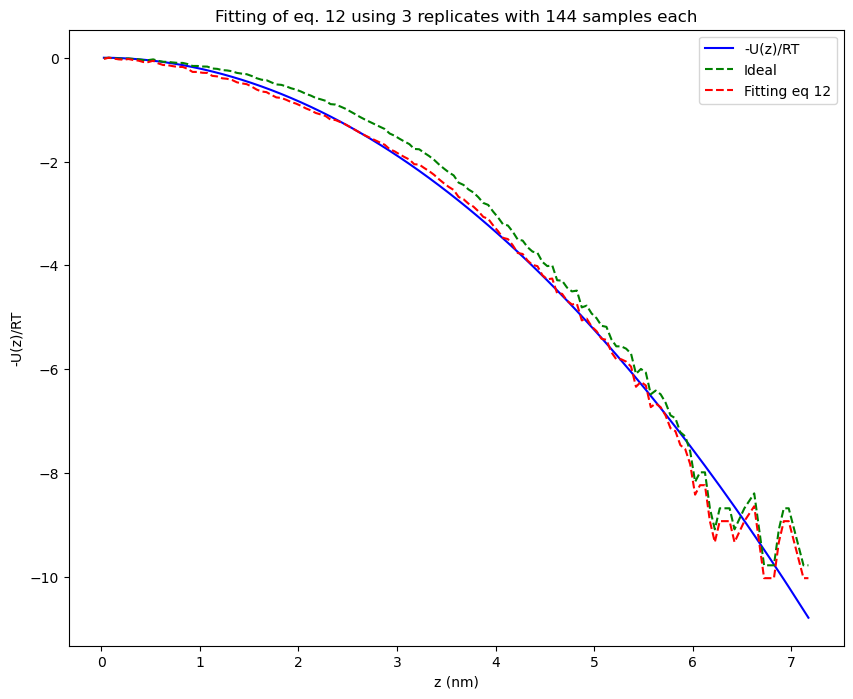

In [19]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $\abs{f'(x)}\delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

In [20]:
norm = 188/(4.8*4.8)
print(norm)

8.159722222222223


In [21]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [22]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

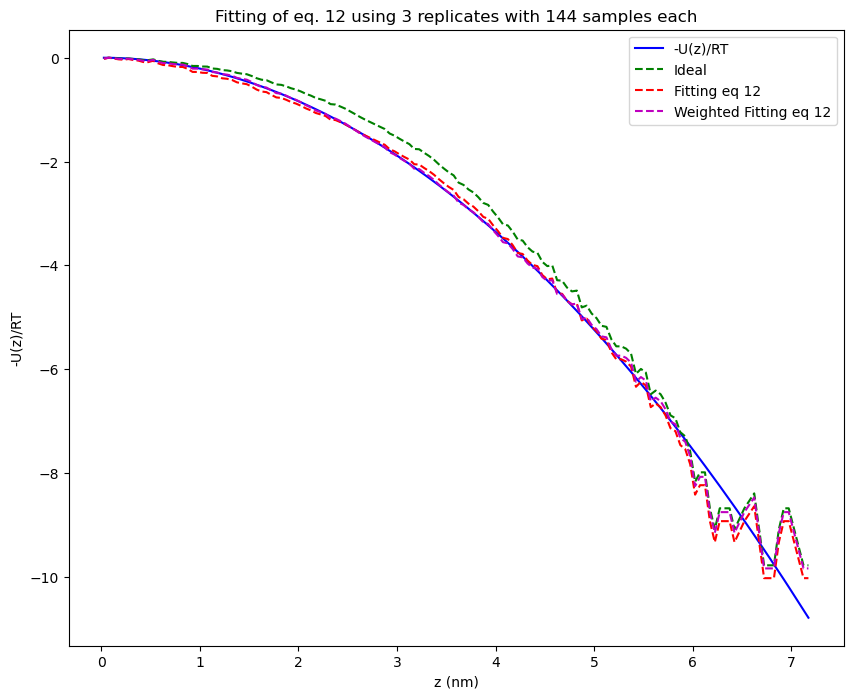

In [23]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

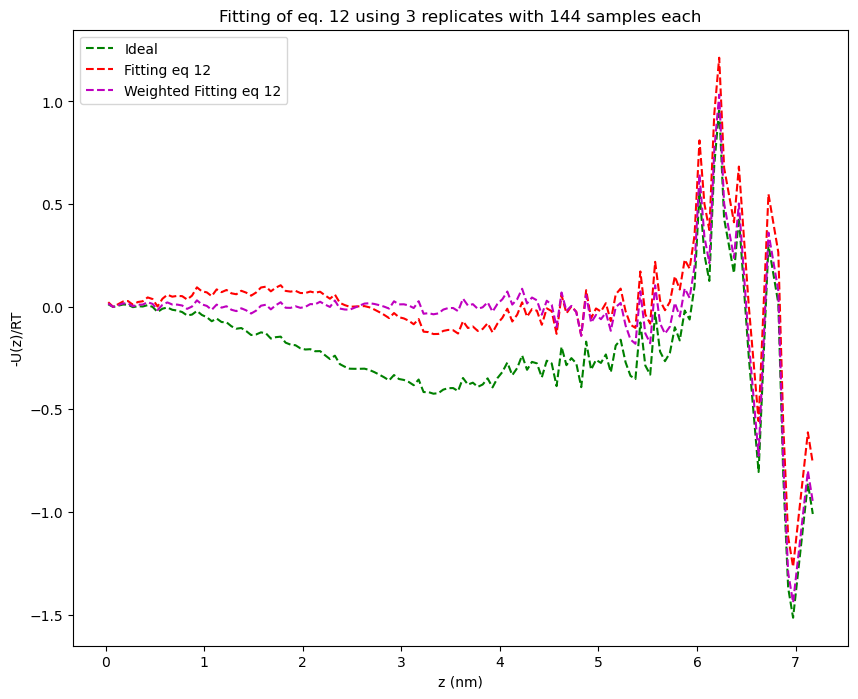

In [24]:
# plot the results
plt.figure(figsize = (10,8))
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, y_values-calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [25]:
zlim = 4

In [26]:
np.std(y_values[z_fit<zlim]-calc_y(result.x,c_fit[z_fit<zlim]))

0.07174155763396328

In [27]:
np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))

0.016195388582744018

Compare the distribution of the parameters with the fit!

In [28]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 1.4401255650435434
alpha1 = 0.2888230424190373
alpha2 = -0.02400355411439836


In [29]:
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

B = 8171.673226824948
alpha1 = -0.09898792032437297
alpha2 = 0.042696173575514244


And we expect that the parameters will be more consistent between runs with weighting.

In [30]:
trialp = [4, 0.1,0.0]
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Parma 0 = 1692.3553951779827 +/- 5766.953006428466


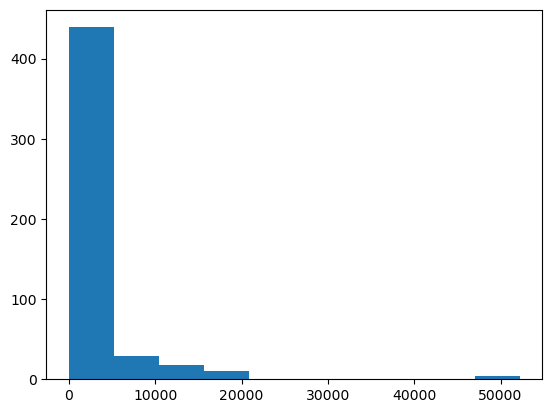

Parma 1 = 0.4071365003886803 +/- 0.3788738752508518


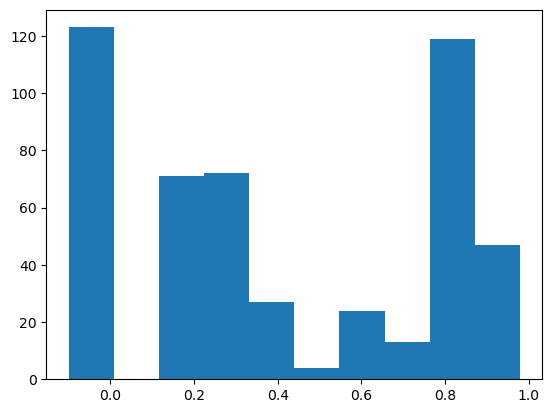

Parma 2 = -0.02510156842476885 +/- 0.04366201094943478


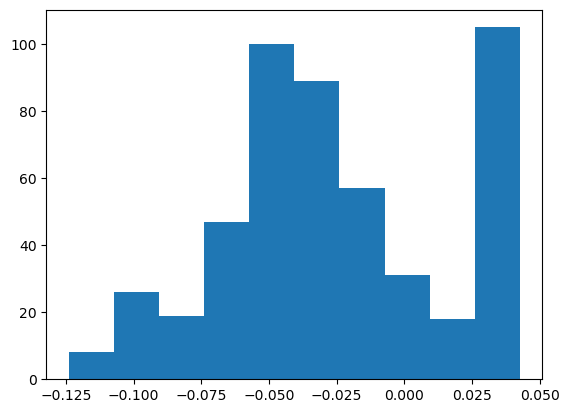

In [31]:
# Perform bootstrapping with unweighted fit
n_bootstrap = 500
bootstrap_params = bootstrap_profiles(concentration_profiles, n_bootstrap, residuals)

for i in range(len(trialp)):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Parma 0 = 1.3852369570014098 +/- 0.65721596253297


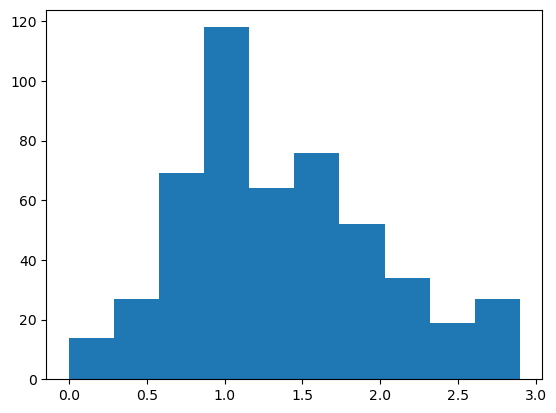

Parma 1 = 0.34749854202074665 +/- 0.11805693607598078


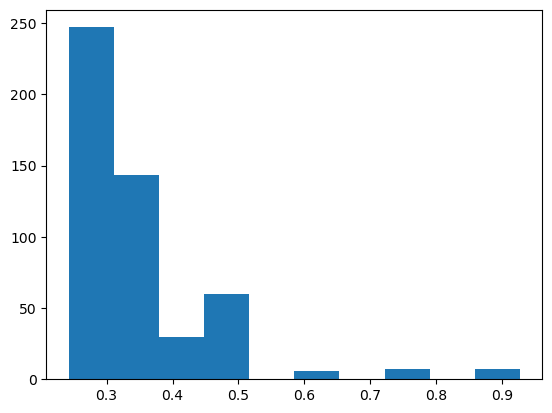

Parma 2 = -0.030924714244267508 +/- 0.009615525016548


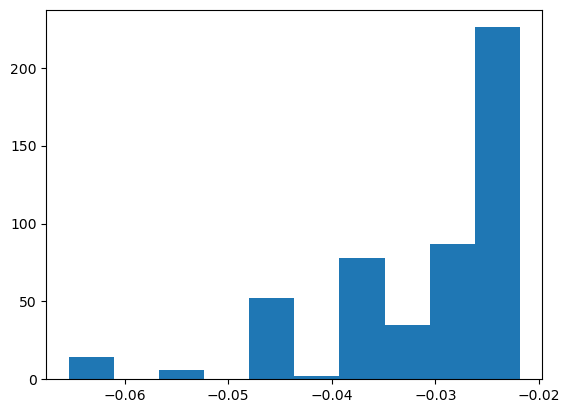

In [32]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params  = bootstrap_profiles(concentration_profiles, n_bootstrap, weighted_residuals)

for i in range(len(trialp)):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

To observe how this works, we first do a trial problem. We generate data from a spring with a spring constant of `setconst`, and take the positive half.  We normalize such that the total number of particles is 100. This is our collected distribution.  We wish to recover the correct parameters for this distribution.  We treat it as a single parameter model with the force constant.  

Some initial math: if the force constant is $k$, then the unnormalized density is $e^{-kz^2/2RT} = e^{-x^2/2\sigma^2}$, so $\sigma^2 = RT/k$, and $\sigma = \sqrt{RT/k}$. The normalization constant for the Gaussian is $\sqrt{2\pi\sigma^2} = \sqrt{2\pi R T/k}$, which is $\sqrt{\pi R T/2k}$ for the half Gaussian.

In [33]:
from scipy.integrate import quad

In [34]:
setconst=60
Np = 100

In [35]:
zp = np.sqrt(R*T/setconst)*np.random.randn(100000)
zph = zp[zp>0]

In [36]:
zp_ideal = lambda z: np.exp(-setconst*z*z/(2*R*T))
zp_norm = quad(zp_ideal,0,100)[0]
print(zp_norm)
zp_norm = np.sqrt(np.pi*R*T/(2*setconst))
print(zp_norm)

8.080942810052731
8.080942810052731


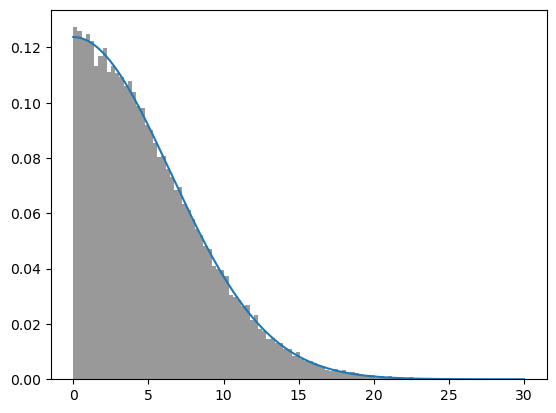

In [37]:
zgrid = np.linspace(0,30,1000)
plt.plot(zgrid,zp_ideal(zgrid)/zp_norm)
plt.hist(zph,density=True,bins=100,color='k',alpha=0.4)
plt.show()

If $p_{ideal} = e^{-U/RT}$, then the concentration is $(N_p/p_{norm})\times p_{ideal}(z)$, and the probability of a particle occuring at a given distance is $p_{ideal}(z)/p_{norm}$.

We now assume that we don't know what distribution the data is taken from, but whsh to figure out the best fit of this distribution to a paramterized distribution.  We assume our parameterized concentration is of the form $f(a,z) = N e^{-az^2/2RT}$, multiplied by any needed normalizing constant $N$ to satisfy the total amount. The logarithm of this probability is $\ln p(a,z) = -\frac{az^2}{2RT} - \ln N$. We can figure out the normalizing constant of our parameterized distribution, but we do not know the true distribution, so we may have to estimate the normalizing constant. 


Next, we need to write out a formula for $\prod_i p(a,z_i)$.  Note that this needs to be the **normalized** probability, otherwise we won't be writing products of percentages.

We then attempt to maximize $\prod_i p(a,z_i)$, where the product is over the data samples we have collected.  The values of $a$ that maximize this product will be the maximum likelihood distribution. 

Generally it is more numerically stable, and often easier to work with, to maximize the log likelihood, $\ln \prod_i p(a,z_i) = \sum_i \ln p(a,z_i)$. 

For our trial function, the log likelihood is: 
$-az^2/(2RT)-\ln \sqrt{\pi R T/2a} = -az^2/(2RT) - 1/2 \ln (\pi R T/2) + 1/2\ln a$. If we want to minimize this, we can eliminate any terms that do not involve the parameter $a$, so we can minimize simply $-az^2/RT+ 1/2 \ln a$. 

In [38]:
def logp(a,z):
    return -a[0]*z*z/(2*R*T) + 0.5*np.log(a[0])

Set up the sum of the log probabilities of the data compared to the model.  Multiply it by -1 since we only have minimizers, not maximizers.

In [39]:
def nl(a,z):
    # sum of the log likelihood
    csum = np.sum(logp(a,z))
    return -1*csum

Now minimze!

In [40]:
results = minimize(nl,[4],args=(zph),method='L-BFGS-B')

The result is consistent with the model up to noise!

In [41]:
results.x

array([59.39056063])

In [42]:
results = minimize(nl,[100],args=(zph),method='L-BFGS-B')
print(results.x)

[59.38985408]


We get the right answer to within statistical precision.

### The actual problem

We now apply the problem to the one of the chemical potential of ions trapped in a harmonic potential.

First, import the data.

In [43]:
import pickle
import pdb

In [44]:
with open('ion_array.bin', 'rb') as f:
    zs = pickle.load(f)

In [45]:
ionz = np.abs(np.array(zs)-72)/10 # rescale the data.

In [46]:
zvals = ionz.flatten()

For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $x$, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{AC_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [47]:
from scipy.integrate import quad, simpson, trapezoid

In [48]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T)
cz_ideal = lambda z: np.exp(-red_U_app(z))

In [49]:
ideal_norm = quad(cz_ideal,0,10)[0]
print(ideal_norm)
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
print(ideal_norm)

1.9356824136314768
1.9356824138152555


In [50]:
cmax_ideal=N_s/(4.8*4.8*ideal_norm)
print(cmax_ideal)

4.215424061294903


One issue is doing the integration of the model parameter to normalize it. 

We could try to take advantage of importance sampling - if we have two unnormalized probability distributions $q_i$ and $q_j$ ($p_i$ normalized), and we have samples from $q_i$, then we can have

$1 = \int p_j(z) dz \\
= \int \frac{p_j(z)}{p_i(z)}p_i(z) \\
= \int \frac{q_j(z)/Z_j}{q_i(z)/Z_i} p_i(z) \\
= \int \frac{Z_i}{Z_j} \frac{q_j(z)}{q_i(z)} p_i(z) \\
\approx \frac{Z_i}{Z_j} \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)} \\
\frac{Z_i}{Z_j} \approx \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)}
$

 So if we know the ideal solution normalizing factor, we can find

$Z_{trial} = Z_{ideal} \frac{1}{N} \sum_n \frac{q_{ideal}(z)}{q_{trial}(z)} =  Z_{ideal} \left \langle \frac{q_{ideal}(z)}{q_{trial}(z)} \right \rangle$

However, this doesn't actually appear work if we using this equation to optimize the parameters, because if we have a mismatch between the trial function and the data sampled; if the trial function functional form doesn't actually match the PDF measured, then we will continually get worse results.

Let's do something silly/simple and assume we have enough data, and just take the points that are output, and do Simpson's rule on those.

In [51]:
# define a function that iterates the calculation of a concentration.
def czfunc(a,z,cz):
    # exponential of eq 12 for ln c/cmax for the data points
    cznew = np.exp(logprobfunc(a,z,cz))
    # these indices do not need to be repeated if this is expensive,
    # but if we bootstrap, they will change, so keep for now. 
    zunique,locs = np.unique(z,return_index=True)
    # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],zunique)
    cznorm_ratio = ideal_norm/newarea
    return (cmax_ideal*cznorm_ratio)*cznew

In [52]:
def logprobfunc(a,z,cz,A=A):
    # we need to calculate the maximum concentration 
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [53]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

How many duplicates of each $z$ value are there?  

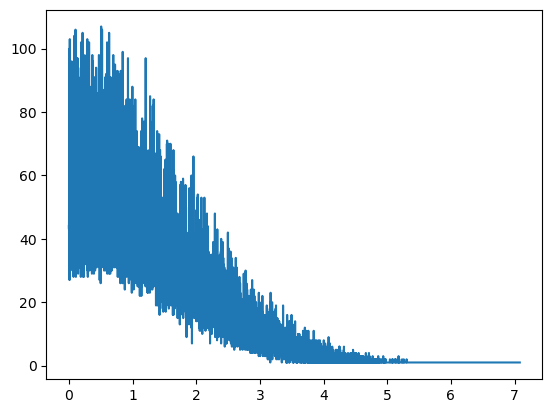

In [54]:
zsparse,zcount=np.unique(zvals,return_counts=True)
plt.plot(zsparse,zcount)
plt.show()

Turns out, quite a few!  We can take advantage of that; each time the same $z$ is processed, it would result in the same number, so we can calculate the contribution for each $z$ once and then mulitply by the number of times it appears.

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 76.48216
1 8.331021
2 1.4046497
3 0.25546739
4 0.049103808
5 0.009644568
6 0.0019933288
7 0.0006577148


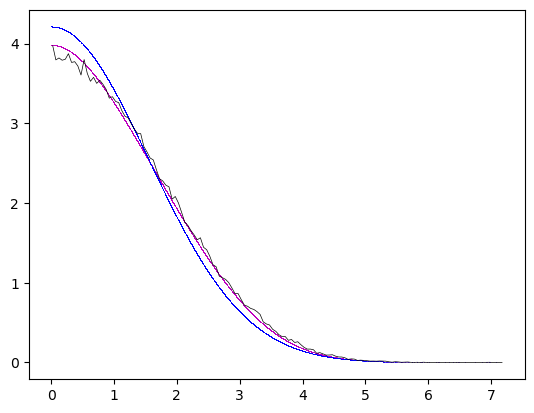

In [55]:
newp = np.array([1.35,0.33,-0.04])
c_new = converge_c(newp,zvals,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zvals,c_new,s=0.1,lw=0.1,c='m')
plt.scatter(zvals,cmax_ideal*cz_ideal(zvals),s=0.1,lw=0.1,c='b')
plt.plot(z,concentration_profiles[0],'k',lw=0.5)
plt.show()

0 13.363842
1 1.5527601
2 0.26444435
3 0.048486248
4 0.009332019
5 0.0018396403
6 0.00037593924


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


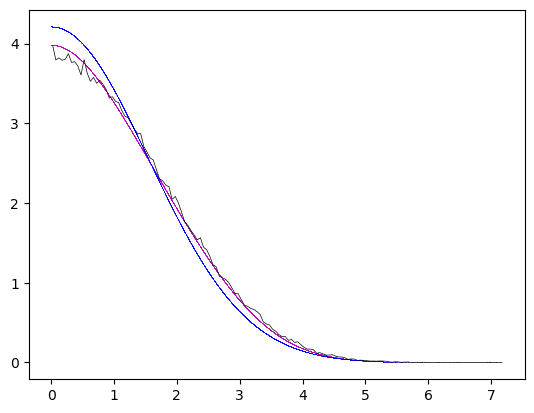

In [56]:
# we can converge faster with sparse data.
newp = np.array([1.35,0.33,-0.04])
zsparse,zcount=np.unique(zvals,return_counts=True)
c_new_sparse = converge_c(newp,zsparse,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zsparse,c_new_sparse,s=0.1,lw=0.1,c='m')
plt.scatter(zsparse,cmax_ideal*cz_ideal(zsparse),s=0.1,lw=0.1,c='b')
plt.plot(z,concentration_profiles[0],'k',lw=0.5)
plt.show()

In [57]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [58]:
from timeit import default_timer as timer

In [59]:
# summing over all the values is slow
start = timer()
results = minimize(neglliter,newp,args=(zvals,c_new),method='Nelder-Mead',options={'maxiter':200})
# this one also works pretty well
#results = minimize(neglliter,newp,args=(zvals,c_new),method='COBYLA',options={'rhobeg':0.001})
end = timer()
print(end-start)

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


303.0894611689728


In [60]:
# plot the results
print(results)
c_opt = converge_c(results.x,zvals,cz_start=c_new,lim=0.0001,verbose=False)
optp = results.x
print(optp)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105700.40625
             x: [ 2.465e+00  2.242e-01 -2.071e-02]
           nit: 112
          nfev: 258
 final_simplex: (array([[ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


[ 2.46487201  0.2241518  -0.02070808]


In [61]:
# yep, we have reduced the negative log likelihood, 
# i.e. maximized the likelihood
print(neglliter(newp,zvals,c_new,doeval=True))
print(neglliter(optp,zvals,c_opt,doeval=True))

105751.96875
105700.5625


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


See what the improved solution looks like! (red line vs magenta line)

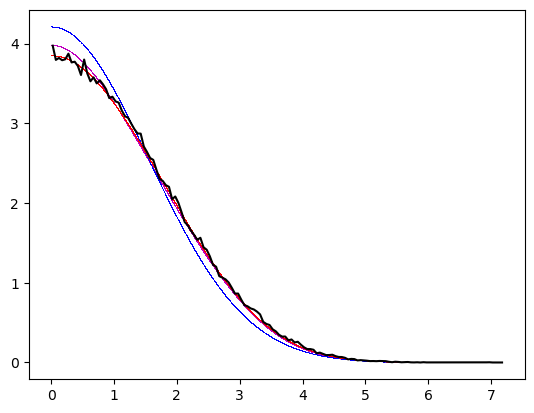

In [62]:
plt.scatter(zvals,c_new,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zvals,cmax_ideal*cz_ideal(zvals),s=0.1,lw=0.1,c='b')
plt.scatter(zvals,c_opt,s=0.1,lw=0.1,c='r')
plt.show()

Note we can make this much faster by noting that there are a lot of repeats of each value, so we can simplify the sum (MIGHT be slightly different because of rounding).


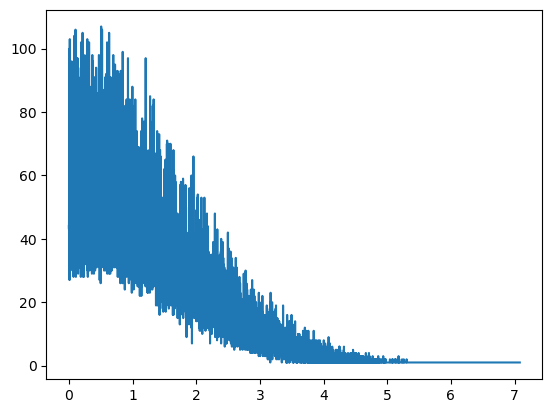

In [63]:
zsparse,zcount=np.unique(zvals,return_counts=True)
plt.plot(zsparse,zcount)
plt.show()

In [64]:
# this is now much faster, and gives essentially the same answer.
start = timer()
results = minimize(neglliter,newp,args=(zsparse,c_new_sparse,zcount),method='Nelder-Mead')
end = timer()
print("time=",end-start)
print(results)
full_opt = results.x

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


time= 1.3900399871636182
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105700.49894010276
             x: [ 2.383e+00  2.246e-01 -2.056e-02]
           nit: 97
          nfev: 219
 final_simplex: (array([[ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


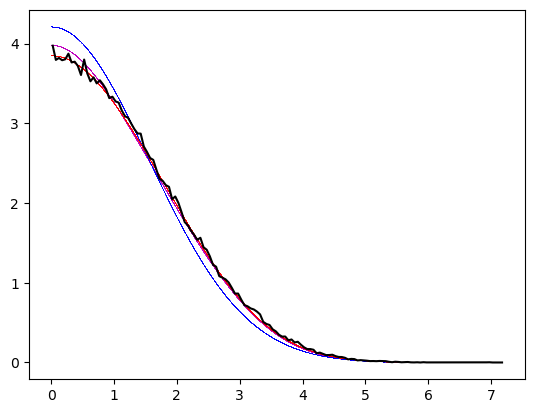

In [65]:
# now plot the new data 
c_opt_sparse = converge_c(results.x,zsparse,cz_start=c_new_sparse,verbose=False)
plt.scatter(zsparse,c_new_sparse,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zsparse,cmax_ideal*cz_ideal(zsparse),s=0.1,lw=0.1,c='b')
plt.scatter(zsparse,c_opt_sparse,s=0.1,lw=0.1,c='r')
plt.show()

Note that the parameters are somewhat different, but the curves are about the same; the space appears to be relatively degenerate, in that there's a large volume of parameters that all give similar results. But that's probably OK for osmotic coefficients, as there will also be many parameters that thus give about the same osmotic coefficient. 

This seems to work!  Things to do:

1. Implement bootstrapping. A key here is one can now bootstrap over all the SAMPLES (like 188,000), not the profiles (4).
2. See what happens when you use all the data from the trajectories.  You can just dump them all into one big array - the bootstrapping is on samples, not on the trajectories.
3. See if you can get away with 2 paramters, not 3, and still get a good fit.  
4. Bootstrap around the osmotic coefficient/pressure calculation given the curve - this will be much less noisy than the parameters themselves. 


In [66]:
# Function to perform bootstrapping over _samples_
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

In [67]:
bparams,bcs = bootstrap_samples(zvals,500,neglliter,results.x)

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 [ 2.35654865  0.22364171 -0.02022281] 105577.11071686966


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


1 [ 2.42009808  0.21758857 -0.0192868 ] 105529.0945282653


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


2 [ 2.07832899  0.24626036 -0.02422106] 105369.59228562265
3 [ 2.43560474  0.23684181 -0.0231315 ] 105879.53345327365
4 [ 2.77255718  0.21593447 -0.01919526] 106208.29699129857
5 [ 2.32985685  0.23796304 -0.02334225] 105674.90919851966


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


6 [ 2.23120348  0.24812521 -0.02417857] 106122.05200702281


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


7 [ 2.34056096  0.22610322 -0.0205696 ] 105693.11583787602


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


8 [ 2.20546299  0.22989644 -0.02091937] 105540.6609318063


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


9 [ 2.22922888  0.21705972 -0.01717297] 105894.69709619303


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


10 [ 2.32315856  0.22306374 -0.01973163] 105637.75363320293
11 [ 2.40775418  0.24202199 -0.02425655] 105863.1539116746
12 [ 2.62886019  0.22254509 -0.02151065] 105562.2594277418


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


13 [ 3.64475892  0.18641061 -0.01611597] 105633.83678781368
14 [ 2.66139986  0.21233998 -0.01919265] 105545.69060623403


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


15 [ 2.87266157  0.21624557 -0.02042467] 105838.16752106593
16 [ 2.67736032  0.19658622 -0.01578088] 105418.0127039311
17 [ 2.50731268  0.23126554 -0.02196715] 105996.91724583584
18 [ 2.63416397  0.21564072 -0.02016711] 105417.96078936927
19 [ 2.84361512  0.21287094 -0.01949987] 105845.84712454153
20 [ 2.31679356  0.23411837 -0.02183907] 105909.22278303646


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


21 [ 2.66626386  0.23880735 -0.02446517] 106021.19890808681
22 [ 2.32691089  0.24059327 -0.02303536] 106092.35069432939
23 [ 3.07477327  0.21979447 -0.02118059] 106198.8051149707
24 [ 2.42988931  0.25073205 -0.02550884] 106290.96586513307
25 [ 2.26098242  0.22004471 -0.01937776] 105334.08238435374


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


26 [ 2.91277575  0.21297117 -0.02007952] 105722.99189381488
27 [ 2.26403204  0.21621811 -0.01768827] 105654.49985718385
28 [ 1.77815644  0.26312768 -0.02576076] 105258.10783971929
29 [ 2.27716616  0.24337319 -0.02336802] 106055.38536368716
30 [ 2.35711604  0.23632832 -0.02242613] 105975.5839419067
31 [ 1.88451602  0.27425519 -0.02872912] 105599.90593277477
32 [ 2.66903115  0.21393383 -0.01949625] 105630.83387669481
33 [ 1.78785261  0.27026674 -0.0263526 ] 105811.0612581038
34 [ 2.72744936  0.2054448  -0.01772422] 105596.76695697049
35 [ 2.22239734  0.25203917 -0.02573906] 105790.41190796933
36 [ 3.7183373   0.16275047 -0.01072861] 105564.09297765227
37 [ 2.42127411  0.23324729 -0.02190113] 106044.1145793697
38 [ 2.92022694  0.20715957 -0.01874692] 105705.30293493089


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


39 [ 3.12872605  0.20872717 -0.01913285] 106054.06082031093
40 [ 3.0887278   0.2033953  -0.01779921] 105974.82896937824
41 [ 1.79714729  0.28125549 -0.02887211] 105949.18503804108
42 [ 1.99493785  0.25954154 -0.0260852 ] 105649.643622325


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


43 [ 2.97374277  0.2204865  -0.02250019] 105523.40040167513
44 [ 3.06922981  0.19612871 -0.01611481] 105945.0519049458


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


45 [ 2.4045005   0.21648854 -0.01865087] 105604.9653414844


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


46 [ 2.7491094   0.1917176  -0.01506738] 105354.81177828016
47 [ 1.93201653  0.256477   -0.02497211] 105575.73229993256
48 [ 2.37469967  0.2227279  -0.02008588] 105585.91760730911
49 [ 3.25924471  0.19243839 -0.01605396] 105841.69003332626
50 [ 2.03687422  0.26428463 -0.02786341] 105560.61282639658
51 [ 2.4316383   0.21153813 -0.01737683] 105772.25169373878


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


52 [ 2.43722225  0.21370694 -0.01824104] 105576.53487075632
53 [ 2.64663188  0.22235008 -0.02070053] 105934.32448978531
54 [ 1.85398817  0.28182654 -0.02854509] 106317.9250702631


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


55 [ 2.35297934  0.26277827 -0.0277213 ] 106412.2199367952
56 [ 3.80816511  0.1627058  -0.00996428] 105985.11291697357
57 [ 2.17355511  0.24838636 -0.02397743] 105990.40946755582
58 [ 3.15069764  0.18064562 -0.01328265] 105673.40929130382
59 [ 2.63328035  0.207971   -0.01739837] 105903.43027782458
60 [ 2.26194461  0.21815322 -0.01945628] 105082.69742662349


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


61 [ 2.44552397  0.23095353 -0.0227137 ] 105466.72346943834
62 [ 2.8572222   0.21187809 -0.01973086] 105692.84251831082
63 [ 2.89509163  0.19388903 -0.01575836] 105559.18720141293


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


64 [ 2.4637857   0.25491239 -0.02650956] 106429.20542426538
65 [ 3.65293545  0.17190307 -0.01321119] 105435.18294882079
66 [ 2.44756835  0.23969066 -0.02463468] 105539.80880195874
67 [ 2.60958115  0.20989539 -0.01836998] 105561.64050740341


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


68 [ 2.04052823  0.2378966  -0.02068271] 105913.81749495701


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


69 [ 2.43202578  0.22802612 -0.02108244] 105816.84857699202
70 [ 2.04946487  0.26614256 -0.02776081] 105811.72130626187
71 [ 2.21044291  0.2473183  -0.02456387] 105787.05666978763
72 [ 2.03674316  0.26052585 -0.02640946] 105760.97522665457


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


73 [ 1.73260335  0.26206927 -0.02503924] 105242.00902927264
74 [ 2.03882544  0.24529848 -0.02446878] 104995.41592458951
75 [ 4.30024138  0.17525618 -0.01364148] 106108.28812494696
76 [ 3.25782688  0.19418693 -0.01728152] 105473.35137881534
77 [ 2.07082791  0.24118259 -0.02205905] 105746.17183176536
78 [ 2.67918364  0.21467391 -0.01937857] 105799.1208577621
79 [ 2.8734478   0.21573514 -0.019873  ] 106058.20587265491
80 [ 2.30302841  0.22383559 -0.01992381] 105612.24929493855
81 [ 2.65967061  0.19868104 -0.01638996] 105341.82877420036


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.7459998e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


82 [ 2.53782543  0.21957962 -0.01967207] 105827.2633182035
83 [ 2.97282754  0.19444695 -0.01656036] 105416.60201830526
84 [ 2.68923971  0.22853633 -0.02186277] 106190.71402342325
85 [ 2.75968027  0.19678269 -0.01559985] 105713.43974670046
86 [ 1.99926169  0.27632175 -0.02966135] 105882.44302412399
87 [ 2.54253143  0.22812666 -0.02204748] 105715.8949757546
88 [ 2.16644922  0.24063343 -0.02370305] 105256.60622440196


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


89 [ 2.07662215  0.25270077 -0.0256402 ] 105393.11356233271
90 [ 2.67683198  0.21690592 -0.01971778] 105849.27813957375
91 [ 3.36366385  0.1872673  -0.01550716] 105670.84073837557
92 [ 2.77989416  0.23143494 -0.0226341 ] 106320.97335651002
93 [ 2.94498726  0.20375625 -0.01775684] 105827.57398467876
94 [ 2.55506837  0.20383639 -0.01586829] 105863.6713829665
95 [ 3.0576906   0.19759437 -0.0158596 ] 106179.71211617527
96 [ 2.40079096  0.22300341 -0.02073907] 105367.35671200312
97 [ 1.84109923  0.26950104 -0.02679701] 105822.61355538944
98 [ 2.04983449  0.24202707 -0.02161346] 105966.52538600657
99 [ 1.98540663  0.2514551  -0.02337907] 105976.6393453011
100 [ 2.42712488  0.21878706 -0.01958512] 105604.04482059204
101 [ 2.42339676  0.20572992 -0.01708299] 105251.93874898498
102 [ 2.15846776  0.22298439 -0.02030135] 104909.51411646152
103 [ 3.07167087  0.19872191 -0.01746702] 105611.83000619248
104 [ 2.21937881  0.23728289 -0.02277789] 105506.183292575


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


105 [ 2.5778478   0.20548408 -0.01773369] 105310.41512290329


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.5820007e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


106 [ 2.01314026  0.24685454 -0.02385557] 105312.85721222335
107 [ 2.34476081  0.21504077 -0.01741007] 105861.33801397003
108 [ 2.29855979  0.23694059 -0.02265022] 105785.10007150199
109 [ 1.89232634  0.27118079 -0.02807126] 105630.27849736468


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


110 [ 2.33202042  0.21584172 -0.018983  ] 105244.2034685604
111 [ 1.99543701  0.27024276 -0.02928873] 105347.87731706098
112 [ 2.56737294  0.20423294 -0.01728274] 105354.4062316215
113 [ 2.83411283  0.20490939 -0.01780928] 105713.74574656236
114 [ 2.37710682  0.21273585 -0.01845116] 105245.14944663229
115 [ 2.27596806  0.23353916 -0.02192069] 105656.67016633163
116 [ 2.40731458  0.22855628 -0.02217665] 105363.64982582764
117 [ 3.09585615  0.20443364 -0.01833286] 105856.62377487271


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


118 [ 2.46665046  0.20892401 -0.01776209] 105359.60157876862
119 [ 1.94561327  0.25381405 -0.02363232] 105946.77338807238
120 [ 2.46932032  0.20847468 -0.01769131] 105374.65750887076


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


121 [ 2.02340201  0.26042966 -0.0260501 ] 105866.34917426253
122 [ 2.87597602  0.19243429 -0.0160314 ] 105267.70363653386
123 [ 2.33833178  0.23264769 -0.0222003 ] 105633.97899763798
124 [ 2.20723876  0.23747191 -0.02256374] 105530.85476972321
125 [ 2.02393349  0.25440786 -0.02473359] 105804.88118462023
126 [ 2.89392778  0.19465452 -0.01598717] 105562.90814238833
127 [ 2.6530498   0.21087314 -0.01878603] 105546.15222328136
128 [ 1.93376863  0.27644824 -0.02833537] 106220.42637606712
129 [ 2.28959668  0.2404807  -0.02307827] 105958.10521863084
130 [ 2.50747616  0.22710542 -0.02095436] 105991.49598229658
131 [ 2.74539346  0.22088893 -0.02113328] 105767.00555500679
132 [ 3.62156942  0.18198546 -0.01487954] 105701.56544099699


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


133 [ 2.17195091  0.23298982 -0.02061883] 105898.25327512815
134 [ 2.84653866  0.18673609 -0.01438479] 105354.4998036962
135 [ 2.56431496  0.22069368 -0.02020176] 105836.59878827732
136 [ 1.5761458   0.3037237  -0.03163894] 105947.0556926107
137 [ 2.27444182  0.22725544 -0.02175455] 105048.42399822189
138 [ 2.61241012  0.23306045 -0.02271686] 106111.33596893288
139 [ 2.46700021  0.21035032 -0.01700551] 105912.22027340347
140 [ 3.29847079  0.19371854 -0.01596048] 106082.63656404361


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


141 [ 3.56174337  0.18666424 -0.01449926] 106281.48758951064
142 [ 2.03918293  0.25149666 -0.02426876] 105733.18658002939
143 [ 1.94814137  0.26030423 -0.02583331] 105644.1906114588
144 [ 2.57434045  0.21391857 -0.01927636] 105481.62451051858
145 [ 3.30430019  0.1712008  -0.01261307] 105197.10411981457
146 [ 3.28061107  0.18137972 -0.01389483] 105657.97988909899
147 [ 1.99470629  0.25083598 -0.02444113] 105414.6812751409
148 [ 2.40406464  0.21479838 -0.01852495] 105516.59982687187
149 [ 2.04893895  0.27740253 -0.03023368] 105872.22890376089


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


150 [ 2.34952511  0.2143435  -0.01755307] 105751.17134591496
151 [ 2.68498926  0.20204552 -0.0163141 ] 105833.02595262672
152 [ 2.26335741  0.21815465 -0.01852588] 105465.42966255179
153 [ 3.51080343  0.17107441 -0.01196816] 105688.2396236844
154 [ 1.83194754  0.26305149 -0.02570045] 105539.91687431518
155 [ 2.56221262  0.24921892 -0.02671047] 105909.0816196056
156 [ 2.96387749  0.20784572 -0.01773698] 106301.09846497707
157 [ 2.2274228   0.24617343 -0.02415642] 105912.15224129085


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


158 [ 1.98471081  0.25741423 -0.02540101] 105641.66190262427
159 [ 2.35358851  0.23882277 -0.02325893] 105838.3195458778
160 [ 2.20565881  0.22583753 -0.0200046 ] 105460.55648296628
161 [ 2.24560244  0.23621267 -0.02243976] 105628.02338820403
162 [ 2.71464334  0.21597957 -0.01969624] 105851.4521935325
163 [ 1.56911052  0.29873446 -0.03140677] 105436.87759769149
164 [ 2.78836879  0.19379481 -0.01578324] 105335.18845145845


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.7459998e+00
 6.9129996e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


165 [ 2.30644516  0.25036117 -0.0261583 ] 105574.05806782817
166 [ 2.39995625  0.2225149  -0.02078885] 105326.4533170076
167 [ 2.32018819  0.23591377 -0.02284846] 105614.4964121831
168 [ 2.08409807  0.25162814 -0.02465216] 105757.59089655468
169 [ 2.80166414  0.19509288 -0.01480093] 105981.85092927373
170 [ 2.16451223  0.25286854 -0.02488653] 106025.33650106158
171 [ 2.83325039  0.20595435 -0.01688502] 106253.49495520873
172 [ 2.16010418  0.24610378 -0.02299085] 106129.6914882611
173 [ 2.40220507  0.23661408 -0.02383078] 105448.58587531275
174 [ 2.01814787  0.25921667 -0.02542952] 106053.13031200998


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


175 [ 3.11462762  0.19006331 -0.01575734] 105496.31621939006
176 [ 2.25799994  0.23754331 -0.02336076] 105420.91229116793
177 [ 2.52127589  0.21663473 -0.01880499] 105883.72023953323
178 [ 2.3036148   0.24507071 -0.02424618] 105923.56178305733
179 [ 2.66227425  0.21615496 -0.0200571 ] 105541.25136609166
180 [ 3.36605217  0.20620357 -0.0188237 ] 106248.30454068621
181 [ 2.06269173  0.24996577 -0.02438093] 105659.60093992137
182 [ 3.07219087  0.18129075 -0.0134871 ] 105546.13935824583
183 [ 2.44055925  0.20296848 -0.01618316] 105407.66222964232
184 [ 2.35885832  0.23922535 -0.022905  ] 106061.74272179717
185 [ 2.20589239  0.23429552 -0.02117108] 105822.50295787201
186 [ 2.74831537  0.237984   -0.02484855] 105927.89391601947
187 [ 3.06059869  0.18129044 -0.01235998] 106057.82940805129
188 [ 2.65876502  0.20480217 -0.01771988] 105378.92697269005
189 [ 2.42021582  0.23153264 -0.02273993] 105458.04749785371
190 [ 2.0289525   0.24142064 -0.02198455] 105707.08352815639
191 [ 2.31340772  0.2084

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


231 [ 2.95349692  0.19332303 -0.01501677] 105924.06310323092
232 [ 2.12005958  0.23164583 -0.020251  ] 105717.59981443627
233 [ 2.22965202  0.23871495 -0.02288445] 105636.98415386096
234 [ 2.29866477  0.25757163 -0.02715121] 105984.05149304592
235 [ 2.61110566  0.22108375 -0.02042392] 105856.65028261047
236 [ 1.86087109  0.27900849 -0.02905036] 105846.54087260757
237 [ 2.41636072  0.22555818 -0.02132752] 105418.16279982013
238 [ 2.75846272  0.18586449 -0.01356712] 105403.64644778255
239 [ 2.3447045   0.24132617 -0.02417909] 105636.86710710626


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


240 [ 2.52607612  0.22783649 -0.02092622] 106152.11466091825


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


241 [ 2.31804814  0.2312623  -0.02056282] 106109.9029491753
242 [ 3.06797094  0.20001447 -0.01813238] 105466.46337211349
243 [ 2.38311794  0.23962545 -0.02429589] 105525.03070197337
244 [ 2.45271603  0.23736354 -0.02343386] 105820.01235574918
245 [ 2.18087915  0.22547835 -0.02025338] 105255.92315480864
246 [ 3.32578313  0.17812818 -0.0128336 ] 105862.83107772589
247 [ 1.93728258  0.27701031 -0.02972931] 105646.91840591314
248 [ 2.2867565   0.25589409 -0.02702761] 105752.45807647266
249 [ 2.2261438   0.24857444 -0.02482819] 105840.43932577495
250 [ 3.44160138  0.17471483 -0.01297609] 105591.26806123013
251 [ 2.05810762  0.26412213 -0.0273828 ] 105801.28473871418
252 [ 2.73651588  0.18980736 -0.01513698] 105110.5210288815
253 [ 2.31178283  0.24629807 -0.02542146] 105559.35774292426
254 [ 2.03536411  0.25342506 -0.02436352] 105944.81297994078
255 [ 2.88125528  0.19571874 -0.01632057] 105456.83877789603
256 [ 2.32847461  0.21710229 -0.01852088] 105624.94164298054
257 [ 2.59034437  0.222817

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


271 [ 2.15013608  0.24167034 -0.02210883] 106057.73005513448
272 [ 2.18698445  0.25236334 -0.0258828 ] 105630.3287108325
273 [ 2.39704201  0.2381908  -0.02342322] 105824.68320558117
274 [ 1.92057661  0.27604677 -0.02927591] 105660.0849022292
275 [ 2.2007468   0.25569658 -0.02617802] 105872.90733987761
276 [ 3.12962962  0.18269856 -0.0139234 ] 105569.19482292821
277 [ 2.18074709  0.2449518  -0.02444174] 105416.55276921763
278 [ 2.57994855  0.22205703 -0.02159523] 105332.07244365942
279 [ 2.85242215  0.20362532 -0.0178527 ] 105632.11788623211
280 [ 2.76855425  0.21351105 -0.0187413 ] 106085.36718118648
281 [ 2.47221104  0.23548952 -0.02283339] 105992.09916130849
282 [ 2.48733424  0.23665035 -0.02366134] 105750.79875195687
283 [ 3.16175871  0.1862959  -0.01580068] 105133.40080363334
284 [ 1.96174529  0.23471101 -0.02030943] 105421.76093720045
285 [ 2.39071219  0.24970729 -0.02573627] 106041.35184860161
286 [ 2.28217371  0.23310711 -0.02218142] 105486.217018147
287 [ 2.32028234  0.2099266 

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


295 [ 2.93100877  0.20645845 -0.01894523] 105551.93466195442
296 [ 2.12503301  0.25756632 -0.02649337] 105716.47982893862
297 [ 2.67274155  0.20893463 -0.01885023] 105385.86337195135
298 [ 3.35387233  0.18266042 -0.01453946] 105582.55575134483
299 [ 2.78539604  0.19510844 -0.01610995] 105368.74562289276
300 [ 2.45626606  0.21743793 -0.01828733] 105993.37032065196
301 [ 3.86668662  0.17277002 -0.01247875] 106014.79043356996


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


302 [ 3.11973409  0.18006025 -0.01310113] 105651.0634317419
303 [ 2.50325954  0.20052769 -0.01678739] 105011.25478448567
304 [ 2.36693332  0.23939384 -0.0231267 ] 105991.12028171771
305 [ 3.156254    0.19045707 -0.01400993] 106361.90836167464
306 [ 1.94522542  0.25086398 -0.02424298] 105414.50551726851
307 [ 2.54163251  0.21171247 -0.01893116] 105347.5601092479
308 [ 2.11943258  0.26525202 -0.02756803] 106031.2559288896


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


309 [ 2.37979611  0.237658   -0.02310377] 105877.52196143883
310 [ 2.74268355  0.21215819 -0.01872951] 105928.29671145989
311 [ 2.21152269  0.23566215 -0.02180752] 105765.54409332975
312 [ 2.43123369  0.23758159 -0.02318294] 105975.04399103257
313 [ 2.53080468  0.21816224 -0.01947203] 105735.313882242


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


314 [ 2.50980926  0.22869524 -0.02158545] 105928.71399938858
315 [ 2.17732869  0.23144856 -0.02046946] 105806.71003999509
316 [ 1.94137652  0.26318732 -0.02628086] 105774.85045422082
317 [ 3.08259012  0.17592762 -0.0128182 ] 105262.44706919463
318 [ 1.84994932  0.27085832 -0.02746658] 105692.99932142715
319 [ 2.36841395  0.23513109 -0.02280503] 105682.100100503
320 [ 2.64647295  0.20364357 -0.01741818] 105386.58881137184
321 [ 3.45325083  0.18238935 -0.01442608] 105747.59757925154
322 [ 1.86740732  0.26766618 -0.02714472] 105522.3655309526
323 [ 2.1479342   0.24099422 -0.0226753 ] 105704.35817199969
324 [ 1.96796617  0.23212351 -0.01983309] 105396.69046048305
325 [ 2.14570364  0.25626106 -0.02550342] 106100.85291312498
326 [ 2.70616724  0.21314703 -0.01832848] 106114.83267657175


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.5820007e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


327 [ 2.39039081  0.22115934 -0.02088675] 105062.099116242
328 [ 2.70493318  0.23633437 -0.02457427] 105792.5419760384
329 [ 2.74977389  0.20681822 -0.01697161] 106153.1805150941
330 [ 2.2544146   0.22660093 -0.02014863] 105676.7610554305


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


331 [ 1.91261453  0.26174177 -0.02753873] 104869.1511808078
332 [ 2.49927136  0.20384223 -0.01657844] 105416.14121591432
333 [ 2.49658146  0.22288229 -0.02090234] 105537.5790388696


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


334 [ 1.73512792  0.27446798 -0.027589  ] 105423.2467283216
335 [ 3.71044459  0.18353593 -0.01467287] 106035.33318338756
336 [ 2.4662055   0.23420624 -0.02338468] 105594.24751223868
337 [ 2.59434979  0.20926043 -0.0178077 ] 105705.27488316434
338 [ 2.23765264  0.24137639 -0.02277916] 106055.00392067598
339 [ 2.3790492   0.22547871 -0.02070793] 105576.55158339415
340 [ 2.63813035  0.21911271 -0.02131035] 105284.01849247818
341 [ 2.44161145  0.22079542 -0.01893559] 106095.44775641667
342 [ 2.19716058  0.2460341  -0.02490403] 105374.40058217166
343 [ 2.23202471  0.24856682 -0.02493601] 105761.74062829008
344 [ 1.89246542  0.26031643 -0.025585  ] 105598.51050380371
345 [ 2.25644907  0.23569402 -0.02207933] 105790.09609674657
346 [ 2.67864644  0.205745   -0.0169382 ] 105867.13376366647
347 [ 1.84136876  0.25993769 -0.02530899] 105453.62342657574
348 [ 2.40139728  0.21540909 -0.01863516] 105595.03034879689
349 [ 3.30786073  0.19839861 -0.01768319] 105807.81185465858
350 [ 2.92262924  0.20725

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


370 [ 3.17946968  0.17866158 -0.0127638 ] 105675.13437514467
371 [ 2.79759379  0.20154383 -0.01696847] 105708.80562317661
372 [ 1.86280687  0.28281808 -0.02985711] 105892.61548017783
373 [ 3.10198706  0.18847923 -0.01455536] 105835.30144487212
374 [ 2.97899513  0.20839759 -0.0199644 ] 105378.16106904272
375 [ 2.56577167  0.22993424 -0.021953  ] 106018.98302291465
376 [ 2.52670443  0.20587703 -0.01732472] 105384.21124943675
377 [ 2.53229387  0.21786158 -0.01922253] 105851.55645640068
378 [ 2.30403634  0.24137935 -0.02358043] 105822.0467080302
379 [ 2.76906948  0.20639479 -0.01764817] 105844.20532020926
380 [ 1.85571183  0.27456571 -0.0286364 ] 105558.15135905858
381 [ 3.16336405  0.17420569 -0.0126418 ] 105287.71151223616
382 [ 2.18392564  0.22093457 -0.01889035] 105378.94172153049
383 [ 2.71901466  0.2231478  -0.0203765 ] 106316.71754751846
384 [ 2.68038518  0.20740483 -0.01843045] 105410.53327652677


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


385 [ 2.05168306  0.24999428 -0.0234913 ] 105978.30569562607
386 [ 2.4262354   0.23042053 -0.02172236] 105846.31509620148
387 [ 3.04524983  0.21708925 -0.02159469] 105642.38484184747
388 [ 3.03206605  0.20336122 -0.01728524] 106132.58130250596
389 [ 2.18756633  0.2386385  -0.02298804] 105488.60399940594
390 [ 2.60551243  0.2350566  -0.02351293] 105929.27520001418
391 [ 2.17645026  0.2341741  -0.0211924 ] 105751.98174997281
392 [ 1.92035402  0.28609854 -0.03045369] 106253.32021878666
393 [ 2.62066636  0.20803348 -0.01815806] 105489.62691083582
394 [ 3.09219707  0.20298207 -0.01807911] 105823.39417526094
395 [ 2.89253007  0.21006195 -0.01897893] 105864.77143841737
396 [ 2.71496183  0.20711984 -0.01727664] 105945.054351076
397 [ 2.54423912  0.21432828 -0.01907857] 105537.56529023273
398 [ 2.82441234  0.19225013 -0.01531241] 105463.09314794789
399 [ 3.03377868  0.19378727 -0.01593221] 105721.52290184081
400 [ 3.09056927  0.20448012 -0.01792562] 106057.30044222462
401 [ 2.37791179  0.228854

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


424 [ 2.58336474  0.20236008 -0.01591061] 105803.20264045574
425 [ 2.76861917  0.20414638 -0.01793754] 105495.16250200717
426 [ 2.49854083  0.2206055  -0.02030885] 105581.05112063933
427 [ 2.9677514   0.21027642 -0.01933501] 105828.34655902754
428 [ 1.92474596  0.25276886 -0.02411936] 105523.9422855368
429 [ 2.41795952  0.22172822 -0.02066126] 105322.06569038909
430 [ 2.84273994  0.2132946  -0.01957732] 105880.73781250465


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


431 [ 2.79576091  0.22213086 -0.02082557] 106131.87457854366
432 [ 2.25665775  0.25709937 -0.02644118] 106113.61886692423
433 [ 2.26021824  0.24487483 -0.02398731] 105936.2325316277
434 [ 2.62435249  0.21084648 -0.01820243] 105750.43295964283
435 [ 2.58076264  0.23100319 -0.0228884 ] 105767.74694161426
436 [ 2.28980594  0.24535901 -0.02466642] 105712.60396317548
437 [ 3.19488733  0.18504355 -0.01439664] 105670.43513114603
438 [ 2.33854574  0.2289205  -0.02064294] 105935.57065118728
439 [ 2.95819391  0.21214954 -0.01984375] 105785.92488403044


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


440 [ 2.10391244  0.24057154 -0.02257173] 105592.05258246356
441 [ 3.31518269  0.17545386 -0.01334397] 105315.68590976323
442 [ 2.48264314  0.22699201 -0.0213862 ] 105751.10317895067
443 [ 2.74460733  0.20674929 -0.01830181] 105483.91249379671
444 [ 2.59855551  0.23007683 -0.02195597] 106058.4939904385
445 [ 2.20321026  0.25473998 -0.02673092] 105568.78999468827
446 [ 2.904129    0.21140901 -0.01893081] 106037.86693859262
447 [ 2.42480131  0.24209922 -0.02485054] 105669.26113381104
448 [ 1.74188448  0.27983248 -0.02873741] 105562.81597201322
449 [ 2.37453596  0.23576127 -0.02271844] 105792.28834853813
450 [ 2.50097589  0.21867965 -0.01946408] 105753.62235453699
451 [ 2.23074785  0.22997145 -0.02134717] 105429.82358019392
452 [ 1.96913157  0.25149144 -0.02518216] 105067.69854035706
453 [ 2.51289532  0.23103968 -0.02212597] 105935.2670808862
454 [ 3.13985816  0.1858743  -0.01454024] 105609.71465273412
455 [ 1.72912899  0.30048051 -0.03271262] 105962.05914565413
456 [ 2.9905786   0.185838

/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.3300004e+00 6.7459998e+00
 6.8540001e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


464 [ 2.86183527  0.20112853 -0.01687991] 105738.14923711197
465 [ 2.71660684  0.21288598 -0.01944315] 105629.80662212854
466 [ 2.31352199  0.23532334 -0.02263726] 105653.05952888622
467 [ 2.35772068  0.23655291 -0.02260601] 105899.00601396638
468 [ 2.75464268  0.21487175 -0.01953149] 105857.02724996571
469 [ 2.49793668  0.24490735 -0.02462953] 106275.24612871588
470 [ 2.50388845  0.2345406  -0.02242607] 106176.35349743071
471 [ 2.64705869  0.18978939 -0.01499343] 104994.71843368442


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


472 [ 1.96408257  0.25671488 -0.02575784] 105324.43551384866
473 [ 2.02696588  0.25591352 -0.02514488] 105837.2480358919
474 [ 2.38216584  0.23435397 -0.0217747 ] 106104.64100372857
475 [ 2.98655225  0.19608958 -0.0172823 ] 105254.51883455156


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


476 [ 2.179837    0.23001388 -0.02203393] 104905.85552457899
477 [ 3.79114684  0.19061015 -0.01591848] 106348.0941920113


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.7459998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


478 [ 2.93393931  0.19606758 -0.0153824 ] 105991.12304263195
479 [ 2.34660369  0.24230944 -0.02467173] 105543.87510954385
480 [ 2.30871266  0.25694537 -0.02661505] 106158.30336538717
481 [ 2.10537753  0.24596263 -0.02371188] 105614.18913755359
482 [ 2.40330464  0.20935667 -0.01796358] 105229.84317066827
483 [ 2.51951315  0.22382408 -0.02012634] 106064.59198016253
484 [ 2.1081957   0.24813008 -0.02464354] 105491.91341470311
485 [ 3.12044977  0.20784239 -0.01925489] 105853.89032494306
486 [ 2.20963356  0.23919657 -0.02261953] 105769.49263010356
487 [ 2.60784114  0.19767149 -0.01540169] 105569.28467908912
488 [ 2.44395478  0.24050809 -0.02434194] 105747.60693395055
489 [ 1.82394256  0.2602067  -0.02544291] 105320.74944234073


/tmp/ipykernel_378695/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


490 [ 2.60039484  0.22104267 -0.02062752] 105718.01869349579
491 [ 2.09046326  0.2678858  -0.02840636] 105829.50224990712
492 [ 2.35235234  0.23838023 -0.02333424] 105735.14379721336
493 [ 2.18857707  0.25728033 -0.02708071] 105609.82515210369
494 [ 2.05843991  0.23940142 -0.02250536] 105363.36973617859
495 [ 2.22942153  0.23699203 -0.0216978 ] 106008.77986925845
496 [ 3.05330814  0.17866898 -0.01295847] 105444.83726465482
497 [ 2.38809317  0.21301528 -0.0189024 ] 105090.82846165274
498 [ 2.63572546  0.21877317 -0.02031586] 105686.96880552405
499 [ 2.35302695  0.22963937 -0.02132728] 105717.23169436067


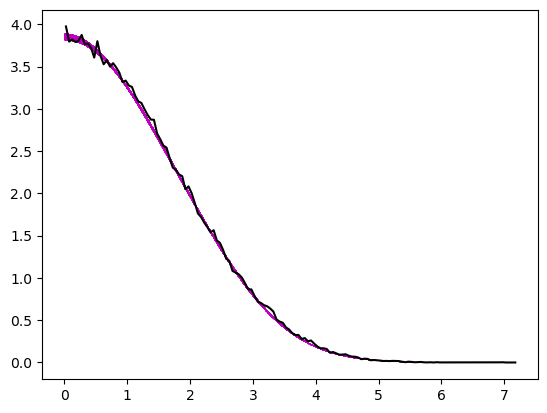

In [68]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse,bcs[i],s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.show()

In [69]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.87252938  0.79342315]
 [-0.87252938  1.         -0.98104222]
 [ 0.79342315 -0.98104222  1.        ]]


Note that parameters are highly correlated, as you can see by the correlation matrix  - there are multiple parameters that give essentially the same result. It may be a 2 parameter fit is enough!  Bootstrapping over osmotic coefficients should give less noisy results.

Parma 0 = 2.520907042081696 +/- 0.44196049824280303


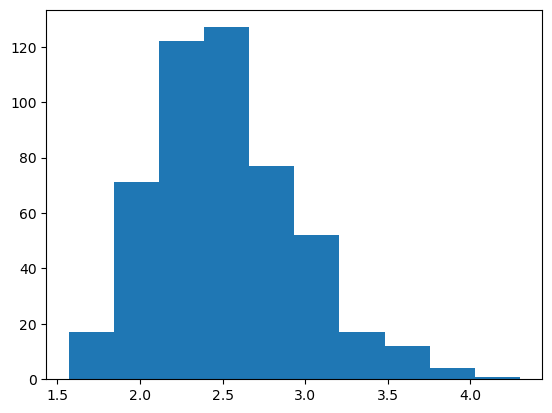

Parma 1 = 0.22510563214800908 +/- 0.02635732864455857


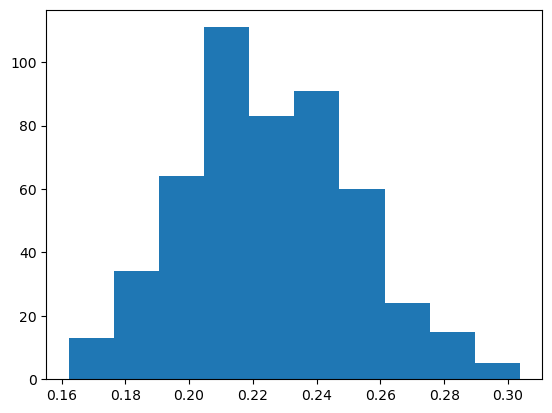

Parma 2 = -0.020821002378562194 +/- 0.004220342423445915


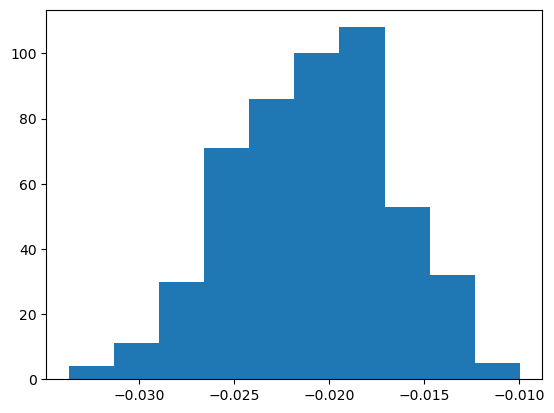

In [70]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Note that the standard deviations of the parameters are lower with the maximum likelihood approximation.

B: 
weighted: 1.33 +/- 0.65
ML: 2.54 +/- 0.44

$\alpha_1$: 
weighted: 0.357 +/- 0.127
ML: 0.223 +/- 0.025

$\alpha_2$: 
weighted: -0.0317 +/- 0.0102
ML:  -0.0205 +/- 0.0041

Note that it is OK that the uncertainties are not within each other, since this is a highly correlated problem, so there are multiple solutions - small change in optimization can lead to large changes in the parameters while still being relatively close. 

In [71]:
def osmotic_pressure(cs,params, nu=2):
    # takes in a concentration, model parameters and nu. 
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4)
    ip = nu*R*T*cs  # this should be the ideal osmotic pressure
    return p,p/ip

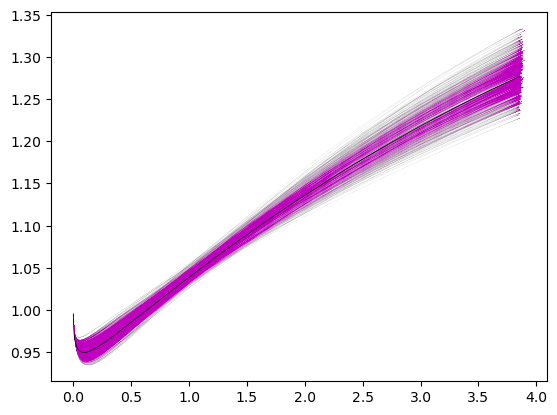

In [72]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse,full_opt)[1]
plt.plot(c_opt_sparse,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

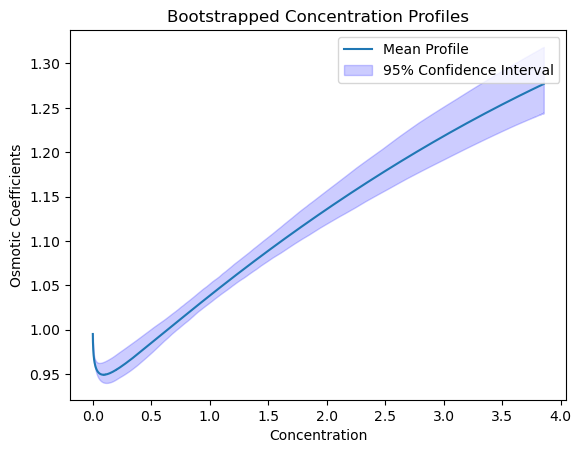

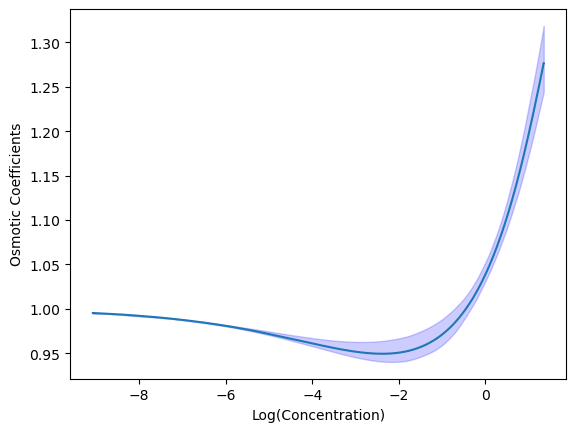

In [73]:
lower_bound = np.percentile(ocs, 2.5, axis=0)
upper_bound = np.percentile(ocs, 97.5, axis=0)
# Plotting the results
plt.plot(c_opt_sparse, opt_oc, label='Mean Profile')
plt.fill_between(c_opt_sparse, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration')
plt.ylabel('Osmotic Coefficients')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()
plt.plot(np.log(c_opt_sparse), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()